
> Learn how COCO object detection dataset's schema is. This file has the same schema. You'll need to discover what those number are. 

> Identify these things for this dataset:
  1) Readme data for class distribution (along with the class names) along with a graph 
  2) Calculate the Anchor Boxes for k = 3, 4, 5, 6 and draw them.
  3) Share the calculations for both via a notebook uploaded on your GitHub Repo


In [6]:
import os
import cv2
import math
import json
import shutil
import random
import numpy as np
from sklearn.cluster import KMeans

In [3]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip 'annotations_trainval2017.zip'

--2021-07-23 17:55:52--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.161.131
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.161.131|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  44.1MB/s    in 5.9s    

2021-07-23 17:55:58 (40.7 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [4]:
annotation_path = '/content/annotations/instances_train2017.json'
with open(annotation_path) as json_file:
  data = json.load(json_file)

In [5]:
data.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [11]:
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import pandas as pd

In [9]:
from collections import defaultdict
img2nboxes = {}

for annotation_dict in data.get('annotations'):
    img_id = annotation_dict.get('image_id')
    img2nboxes[img_id] = img2nboxes.get(img_id,1)+1
nboxes_list = list(img2nboxes.values())
min_nboxes = min(nboxes_list)
max_nboxes = max(nboxes_list)
avg_nboxes = int(sum(nboxes_list)/len(nboxes_list))

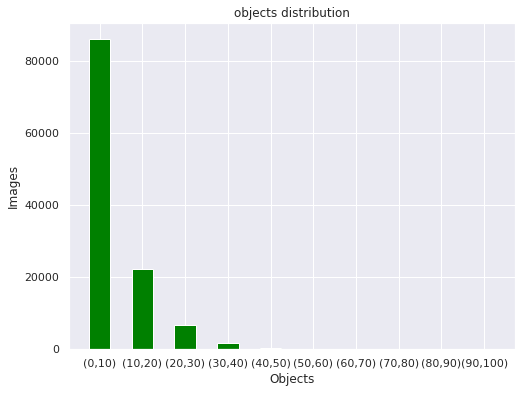

In [15]:
out = pd.cut(nboxes_list, bins=np.arange(0,max_nboxes+10,10), include_lowest=True)

counts = out.value_counts().values
labels = [(int(i.left),int(i.right)) for i in out.value_counts().index.categories]

graph_xind = [i[0] for i in labels] 
ticks = [ '('+str(i[0])+','+ str(i[1])+')' for i in labels]

plt.figure(figsize=(8,6))
plt.bar(graph_xind, counts, color = 'green',tick_label=ticks, width=5)
plt.xlabel('Objects')
plt.ylabel('Images')
plt.title('objects distribution')
plt.show()


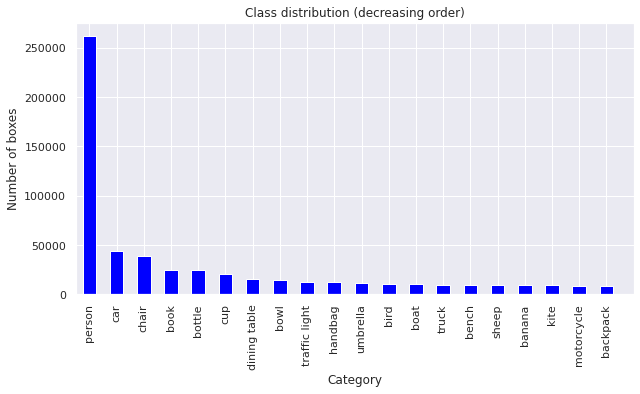

In [39]:
#Code Reference - https://github.com/gkdivya/EVA/blob/main/10_ObjectLocalization/COCO_K-Means/experiments/CocoDataset_AnchorBox_KMeans_Clusters.ipynb
categ_map = {}
for cat in data['categories']:
  cat_id = cat['id']
  cat_name = cat['name']
  categ_map[cat_id] = cat_name

class2nboxes = {} 

for ann in data['annotations']:
    cat_id = ann['category_id']
    cat_name = categ_map[cat_id]
    
    if cat_name in class2nboxes.keys():
        class2nboxes[cat_name] += 1
    else:
        class2nboxes[cat_name] = 1

sorted_c2nb = [(k,v)for k, v in sorted(class2nboxes.items(), reverse=True, key=lambda item: item[1])]

# top 20 classes
top = min(len(sorted_c2nb),20)

# to plot
y = [i[1] for i in sorted_c2nb[:top]]
x = [i[0] for i in sorted_c2nb[:top]]

plt.figure(figsize=(10,5))
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='blue')
plt.xticks(rotation=90) 
plt.xlim(-0.5,len(y))
plt.xlabel('Category')
plt.ylabel('Number of boxes')
plt.title('Class distribution (decreasing order)')
plt.show()

In [19]:
bbox_areas = {} # key: class index, value -> a list of bounding box areas

for ann in data['annotations']:
    area = ann['area']
    cat_id = ann['category_id']
    cat_name = categ_map[cat_id]
    if area <= 0.0:
        continue
    
    if cat_name in bbox_areas.keys():
        bbox_areas[cat_name].append(area)
    else:
        bbox_areas[cat_name] = [area]


bbox_avg_areas = []

for cat in bbox_areas.keys():
    areas = bbox_areas[cat]
    avg_area = int(sum(areas)/len(areas))
    
    bbox_avg_areas.append((cat,avg_area))

bbox_avg_areas = sorted(bbox_avg_areas, key = lambda x: x[1])

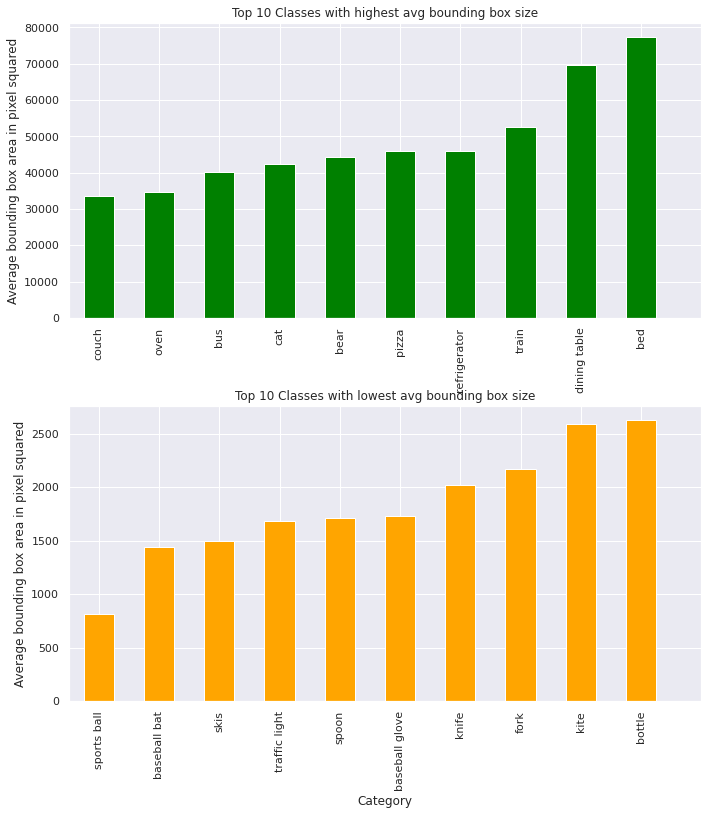

In [40]:
top = min(10, len(bbox_avg_areas))

plt.figure(figsize=(10,10))

y = [item[1] for item in bbox_avg_areas[-top:]]
x = [item[0] for item in bbox_avg_areas[-top:]]

y2 = [item[1] for item in bbox_avg_areas[:top]]
x2 = [item[0] for item in bbox_avg_areas[:top]]

plt.subplot(211)
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='green')
plt.xlim(-0.5,len(y))
plt.xticks(rotation=90) 
plt.ylabel('Average bounding box area in pixel squared')
plt.title('Top '+str(top)+' Classes with highest avg bounding box size')
plt.tight_layout()


plt.subplot(212)
plt.bar(np.arange(len(y2)),y2, width=0.5,tick_label=x2,color='orange')
plt.xlim(-0.5,len(y2))
plt.xlabel('Category')
plt.xticks(rotation=90) 
plt.ylabel('Average bounding box area in pixel squared')
plt.title('Top '+str(top)+' Classes with lowest avg bounding box size')
plt.show()

In [22]:
images_df = pd.DataFrame(data['images'], columns = data['images'][0].keys())
annotations_df = pd.DataFrame(data['annotations'], columns = data['annotations'][0].keys())

In [23]:
annotation_map_df = pd.concat([images_df, annotations_df], 1)[['file_name', 'width', 'height', 'bbox']]
box_df =pd.DataFrame(annotation_map_df['bbox'].values.tolist(), columns =['x', 'y', 'box_width', 'box_height'])
annotation_map_df = pd.concat([annotation_map_df, box_df], 1)
annotation_map_df = annotation_map_df.drop('bbox', axis =1)

In [24]:
annotation_map_df['x'] = annotation_map_df['x'] / annotation_map_df['width']
annotation_map_df['y'] = annotation_map_df['y'] / annotation_map_df['height']
annotation_map_df['box_width'] = annotation_map_df['box_width'] / annotation_map_df['width']
annotation_map_df['box_height'] = annotation_map_df['box_height'] / annotation_map_df['height']

In [25]:
annotation_map_df = annotation_map_df.dropna()

In [26]:
annotation_map_df.isnull().any()

file_name     False
width         False
height        False
x             False
y             False
box_width     False
box_height    False
dtype: bool

In [27]:
hw_array = annotation_map_df[["box_width", "box_height"]].to_numpy()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


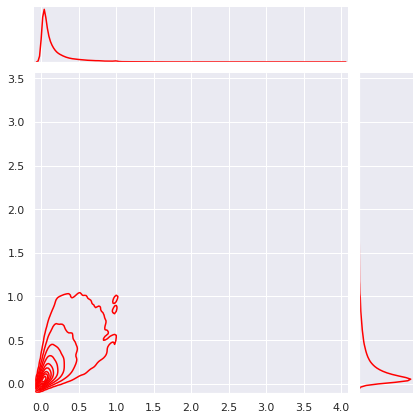

In [29]:
sns.jointplot(hw_array[:,0], hw_array[:,1],kind='scatter',color='red')

In [32]:
class Kmeans:
    def __init__(self, n_clusters, data_points, iterations):
        self.n_clusters = n_clusters
        self.data_points = data_points
        self.iterations = iterations

        self.cluster_centers,self.prediction,self.wcss = self.kmeans_clusters()
        # self.plot_anchor_boxes(self.cluster_centers)
 

    def IOU(self,x,centroids):
        '''
        :param x: a ground truth w,h
            :param centroids: collection of anchor w,h[(w,h),(),...], total k
            :return: a set of IoU values ​​for a single ground truth box and all k anchor boxes
        '''
        IoUs = []
        
        for centroid in centroids:
                w, h = x # ground truth's w, h
                c_w,c_h = centroid #anchorw,h
                # print(c_w,c_h)
                if c_w>=w and c_h>=h: #anchor surrounded by ground truth
                  iou = w*h/(c_w*c_h)
                elif c_w>=w and c_h<=h: #anchor
                  iou = w*c_h/(w*h + (c_w-w)*c_h)
                elif c_w<=w and c_h>=h: #anchor elongated
                  iou = c_w*h/(w*h + c_w*(c_h-h))
                else: #ground truth surrounded by anchor means both w,h are bigger than c_w and c_h respectively
                  iou = (c_w*c_h)/(w*h)
                IoUs.append(iou) # will become (k,) shape
        return np.array(IoUs)
  
    def avg_IOU(self,X):
        '''
            :param X: The set of w,h of ground truth[(w,h),(),...]
            :param centroids: collection of anchor w,h[(w,h),(),...], total k
        '''
        n,d = X.shape
        sum = 0.
        for i in range(X.shape[0]):
            sum+= max(self.IOU(X[i],self.cluster_centers)) #return a ground truth with the maximum value of all anchors in IoU
        return sum / X.shape[0]

    def kmeans_clusters(self): 
        
        kmeans = KMeans(n_clusters=self.n_clusters, init='k-means++', max_iter=self.iterations, n_init=10, random_state=0)
        pred_y = kmeans.fit_predict(self.data_points)
        return kmeans.cluster_centers_,pred_y,kmeans.inertia_        

    def plot_clusters(self):
        plt.scatter(self.data_points[:,0], self.data_points[:,1],c=self.prediction, cmap='magma')
        plt.scatter(self.cluster_centers[:, 0], self.cluster_centers[:, 1], s=90, c='blue')
        plt.xlabel('width')
        plt.ylabel('height')
        plt.title(f'Cluster Plot for k = {self.n_clusters}')
        plt.show()

    def plot_anchor_boxes(self):
        
        xdata = np.array([0.5]*len(self.cluster_centers))
        ydata = np.array([0.5]*len(self.cluster_centers))

        xerror = np.array([list(np.exp(self.cluster_centers[:, 0])/2)]*2)
        yerror = np.array([list(np.exp(self.cluster_centers[:, 1])/2)]*2)

        errorboxes = []

        for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T):
            rect = Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
            errorboxes.append(rect)

        pc = PatchCollection(errorboxes, facecolor='None', alpha=1, edgecolor='r')
        fig, ax = plt.subplots(1)

        ax.add_collection(pc)
        plt.title(f'Anchor Boxes for k = {self.n_clusters}')
        artists = plt.errorbar(xdata, ydata, xerr=xerror, yerr=yerror, fmt='None', ecolor='None')

In [33]:
iou=[]
inertia = []
kmeans={}
cluster_range = range(3, 10)
for i in cluster_range:
  kmeans[i]=Kmeans(n_clusters = i,data_points = hw_array,iterations = 300)
  iou.append(kmeans[i].avg_IOU(hw_array))
  inertia.append(kmeans[i].wcss)

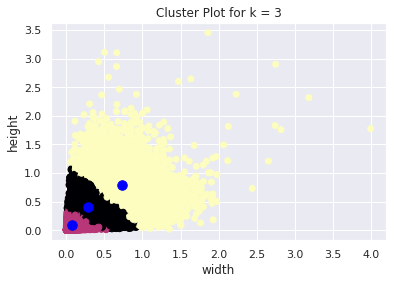

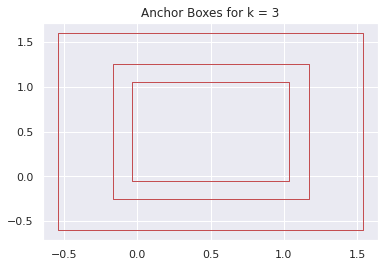

In [34]:
kmeans[3].plot_clusters()
kmeans[3].plot_anchor_boxes()

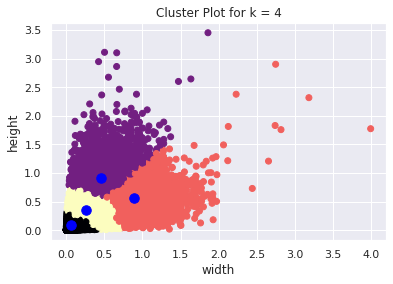

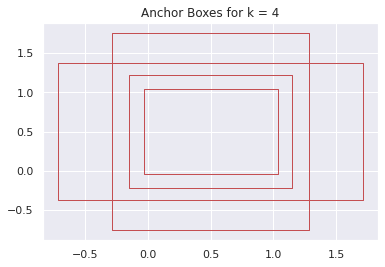

In [35]:
kmeans[4].plot_clusters()
kmeans[4].plot_anchor_boxes()

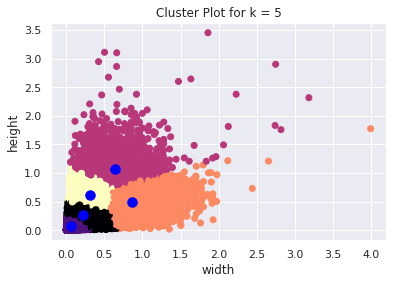

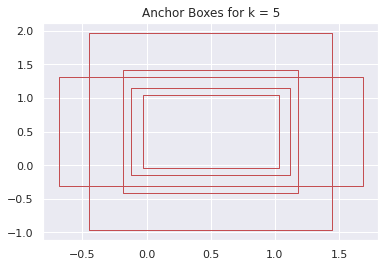

In [36]:
kmeans[5].plot_clusters()
kmeans[5].plot_anchor_boxes()

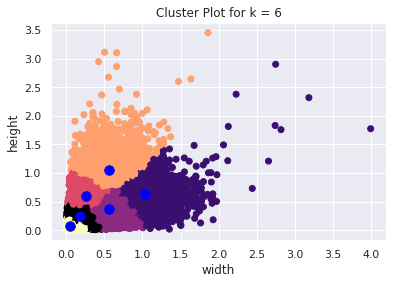

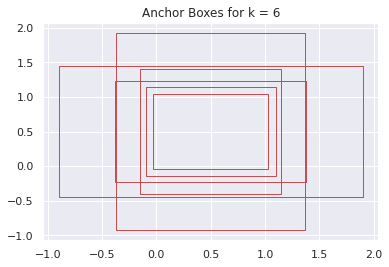

In [38]:
kmeans[6].plot_clusters()
kmeans[6].plot_anchor_boxes()